# Baseline for Hot Topics in Computer Vision - Seminar 2
## Addressing Label Scarcity in the Semantic Analysis of Earth Observation Imagery

## Imports

In [53]:
#google colab
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import datetime
import csv

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Constants

In [54]:
# Mappings for utility
MAP_PERCENT_TO_AMOUNT = {
    "10" : 280,
    "25" : 700,
    "50" : 1400,
    "100": 2799
}

DAMAGE_LEVEL_TO_SCORE = {
    "destroyed" : 4,
    "major-damage" : 3,
    "minor-damage" : 2,
    "no-damage" : 1,
    "no-building" : 0
}

SCORE_TO_DAMAGE_LEVEL = {
    0 : "no-building",
    1 : "no-damage",
    2 : "minor-damage",
    3 : "major-damage",
    4 : "destroyed",
}

NUM_CLASSES = 5  # Number of output classes

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Configs

In [55]:
PERCENT = "10"
TRAIN_SET_SIZE = MAP_PERCENT_TO_AMOUNT[PERCENT]

PRETRAINED = False
BATCH_SIZE = 128
NUM_EPOCHS=50
LEARNING_RATE=0.001
MOMENTUM=0.9
ARCHITECTURE = "rn18"
MODEL_OPTIMIZER = "SGD"

## File Paths

In [56]:
DATASET_DIR = "drive/MyDrive/HTCV-Sem/dataset/"
DATASET_METRICS_DIR = "drive/MyDrive/HTCV-Sem/dataset_metrics"
XVIEW2_TXT_FILE = "drive/MyDrive/HTCV-Sem/dataset/xview2.txt"
MODEL_OUTPUT_DIR = "drive/MyDrive/HTCV-Sem/models/"
MODEL_OUTPUT_FILE = "_model.pth"

## Baseline Classifier

In [57]:
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()

        self.resnet = models.resnet18(pretrained=PRETRAINED)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

## Data Utilities

In [58]:
def calc_mean_and_std_of_dataset(loader):
    mean = 0.0
    std = 0.0
    total_samples = 0

    for images, _ in loader:
        batch_size = images.size(0)
        images = images.view(batch_size, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_samples += batch_size

    mean /= total_samples
    std /= total_samples

    return mean, std

## Normalize Dataset

Calculate mean and standard deviation for RGB images.

Set SAVE_MEAN_AND_STD True to recalculate the dataset's mean and standard deviation

Set LOAD_MEAN_AND_STD True to load the already calculated mean and standard deviation

In [59]:
TRAINING_SET_ENTRIES = open(XVIEW2_TXT_FILE,'r').read().splitlines()[:TRAIN_SET_SIZE]

SAVE_MEAN_AND_STD = False
if SAVE_MEAN_AND_STD:
    pre_norm_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    dataset = torchvision.datasets.ImageFolder(os.path.join(DATASET_DIR,"train"), transform=pre_norm_transform)

    subset = [dataset[dataset.imgs.index((file_path, class_label))] for file_path, class_label in dataset.imgs if os.path.basename(file_path) in TRAINING_SET_ENTRIES]
    dataloader = torch.utils.data.DataLoader(subset, batch_size=BATCH_SIZE, shuffle=False)

    mean, std = calc_mean_and_std_of_dataset(loader=dataloader)
    mean = mean.tolist()
    std = std.tolist()

    if not os.path.exists(DATASET_METRICS_DIR):
            os.makedirs(DATASET_METRICS_DIR)
    with open(os.path.join(DATASET_METRICS_DIR, "data_"+ str(TRAIN_SET_SIZE)+"_original" +".json"), 'w') as json_file:
        json.dump({'mean':mean,'std':std}, json_file)

In [60]:
LOAD_MEAN_AND_STD = False
if LOAD_MEAN_AND_STD:
    with open(os.path.join(DATASET_METRICS_DIR, "data_"+ str(TRAIN_SET_SIZE)+"_original" +".json"), 'r') as data_metrics_json:
        data = json.load(data_metrics_json)

    mean = data['mean']
    std = data['std']
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

print(mean)
print(std)

[0.485, 0.456, 0.406]
[0.229, 0.224, 0.225]


## Load Dataloader

In [61]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

dataset = torchvision.datasets.ImageFolder(
    os.path.join(DATASET_DIR,"train"), transform=transform
)
subset = [dataset[dataset.imgs.index((file_path, class_label))] for file_path, class_label in dataset.imgs if os.path.basename(file_path) in TRAINING_SET_ENTRIES]
dataloader = torch.utils.data.DataLoader(
    subset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2
)

# Train model

In [62]:
TRAIN_MODEL = True
if TRAIN_MODEL:
    model = ResNetClassifier(NUM_CLASSES)
    model.to(DEVICE)

    optimizer = torch.optim.SGD(model.parameters(), LEARNING_RATE, MOMENTUM)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    model.train()
    epoch_loss_list = []
    epoch_accuracy_list = []
    for epoch in range(NUM_EPOCHS):
        step_loss = []
        total = 0.0
        correct = 0.0
        for images, labels in dataloader:
            images, labels =  images.to(DEVICE),labels.to(DEVICE)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            step_loss.append(loss.item())
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = np.array(step_loss).mean()
        epoch_loss_list.append(epoch_loss)
        epoch_accuracy = 100.*correct/total
        epoch_accuracy_list.append(epoch_accuracy)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {epoch_loss:.3f}, Accuracy: {epoch_accuracy:.3f}")


/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/50, Loss: 1.683, Accuracy: 21.071
Epoch 2/50, Loss: 1.487, Accuracy: 45.000
Epoch 3/50, Loss: 1.361, Accuracy: 41.071
Epoch 4/50, Loss: 1.406, Accuracy: 41.071
Epoch 5/50, Loss: 1.359, Accuracy: 41.786
Epoch 6/50, Loss: 1.312, Accuracy: 45.357
Epoch 7/50, Loss: 1.300, Accuracy: 48.929
Epoch 8/50, Loss: 1.242, Accuracy: 50.357
Epoch 9/50, Loss: 1.324, Accuracy: 49.643
Epoch 10/50, Loss: 1.202, Accuracy: 50.000
Epoch 11/50, Loss: 1.236, Accuracy: 50.000
Epoch 12/50, Loss: 1.220, Accuracy: 50.000
Epoch 13/50, Loss: 1.186, Accuracy: 50.714
Epoch 14/50, Loss: 1.154, Accuracy: 50.357
Epoch 15/50, Loss: 1.197, Accuracy: 50.714
Epoch 16/50, Loss: 1.146, Accuracy: 51.071
Epoch 17/50, Loss: 1.129, Accuracy: 50.714
Epoch 18/50, Loss: 1.096, Accuracy: 52.500
Epoch 19/50, Loss: 1.204, Accuracy: 53.571
Epoch 20/50, Loss: 1.142, Accuracy: 53.571
Epoch 21/50, Loss: 1.089, Accuracy: 54.286
Epoch 22/50, Loss: 1.068, Accuracy: 56.071
Epoch 23/50, Loss: 1.138, Accuracy: 56.071
Epoch 24/50, Loss: 1

## Save Model

In [63]:

SAVE_MODEL = True
if SAVE_MODEL:
    out_dir = os.path.join(MODEL_OUTPUT_DIR,ARCHITECTURE +'_size_' + str(TRAIN_SET_SIZE) + '_pretrained_'+ str(PRETRAINED) + "_batch_"+str(BATCH_SIZE)+"_epochs_"+str(NUM_EPOCHS)
                           +"_optim_" +MODEL_OPTIMIZER + "_lr_"+str(LEARNING_RATE) + "_mom_"+str(MOMENTUM))
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    TIME_NOW_STR = datetime.datetime.now().strftime("%m-%d-%Y_%H-%M-%S")
    SAVE_MODEL_FILE = os.path.join(out_dir,TIME_NOW_STR)
    torch.save(model.state_dict(), SAVE_MODEL_FILE + '.pth')


## Plot Training Loss and Accuracy

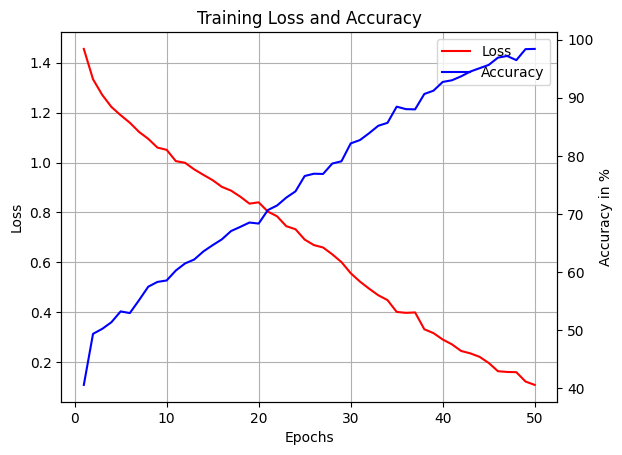

<Figure size 640x480 with 0 Axes>

In [64]:
if TRAIN_MODEL:
    # Plot Loss
    fig, ax1 = plt.subplots()
    ax1.plot(range(1,NUM_EPOCHS+1), epoch_loss_list, 'r-', label='Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss and Accuracy')
    ax1.grid(True)

    # Plot Accuracy
    ax2 = ax1.twinx()
    ax2.plot(range(1,NUM_EPOCHS+1), epoch_accuracy_list, 'b-', label='Accuracy')
    ax2.set_ylabel('Accuracy in %')

    # Add Legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + lines2
    labels = labels1 + labels2
    ax1.legend(lines, labels)

    plt.show()

    plt.savefig(os.path.join(out_dir, 'train_loss_accuracy.svg'), format='svg')

## Test Model

In [65]:
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DATASET_DIR, "test"), transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=2, pin_memory=True)

In [66]:
LOAD_MODEL = False
LOAD_MODEL_FILE = MODEL_OUTPUT_DIR + "size_280_pretrained_False_batch_32_epochs_15_optim_SGD_lr_0.01_mom_0.9/"+ "06-23-2023_18-20-16.pth"
if LOAD_MODEL:
    model = ResNetClassifier(NUM_CLASSES)
    model.load_state_dict(torch.load(LOAD_MODEL_FILE))

In [67]:
model.eval()
model.to(DEVICE)

y_pred, y_truth = [], []

with torch.no_grad():
    for idx,(images, labels) in enumerate(test_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_truth.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
accuracy = correct / total
y_truth = torch.tensor(y_truth)
y_pred = torch.tensor(y_pred)

## Plot Confusion Matrix
Calculate Overall and Average Accuracy

Overall Accuracy: 0.538
Average Accuracy: 0.352


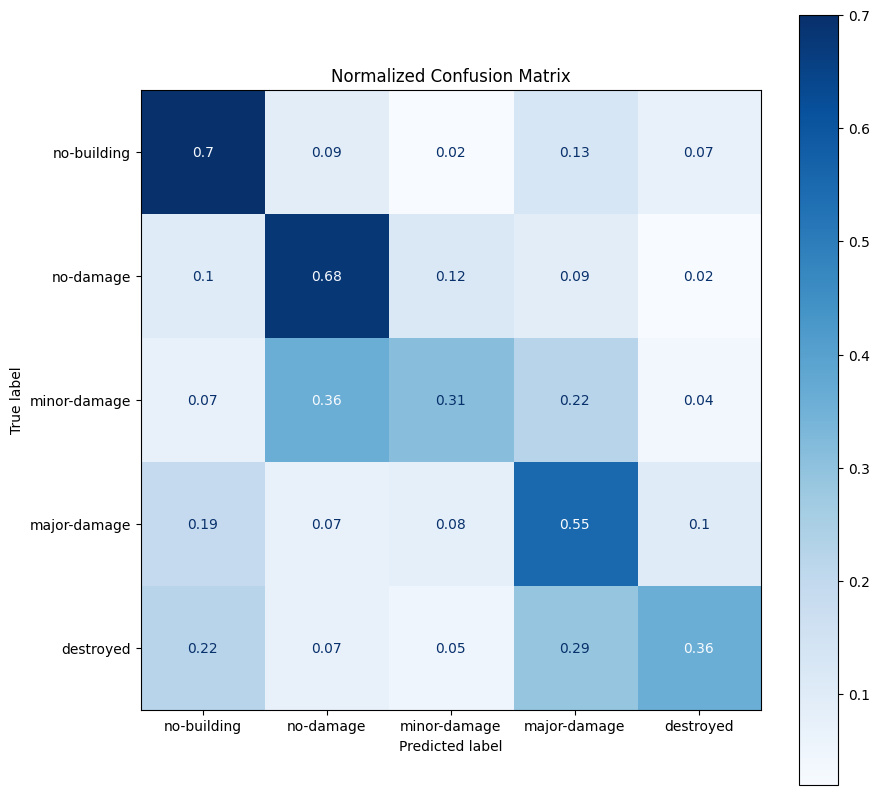

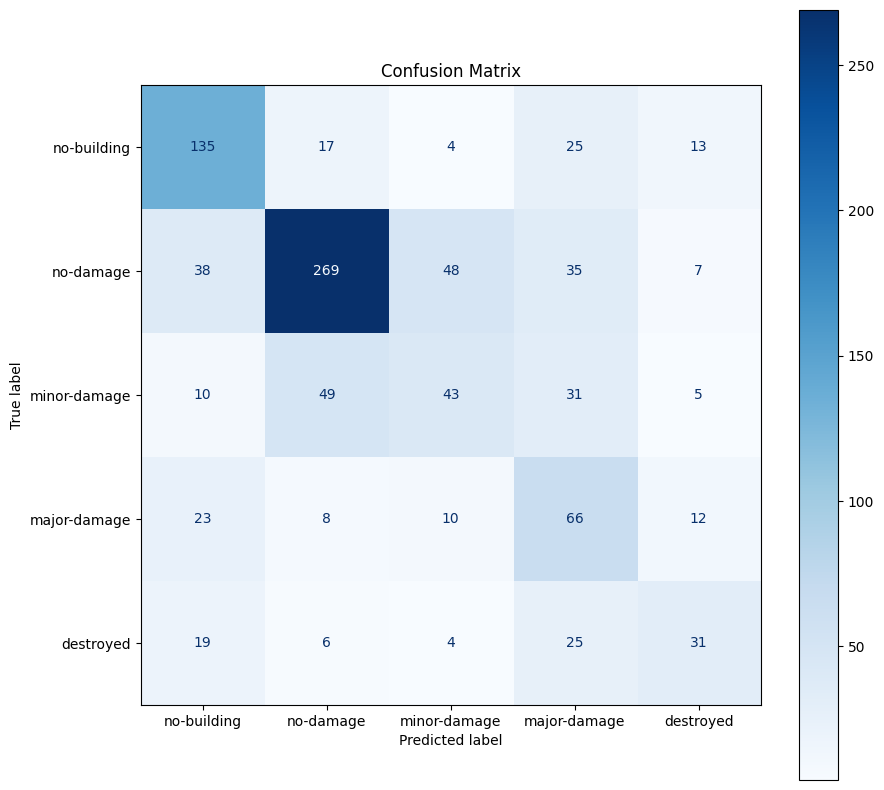

In [68]:
cm_norm = confusion_matrix(y_truth, y_pred, normalize="true")
cm = confusion_matrix(y_truth, y_pred)
l = [SCORE_TO_DAMAGE_LEVEL[i] for i in range(NUM_CLASSES)]

overall_accuracy = np.sum(np.diag(cm))/np.sum(cm)
print(f'Overall Accuracy: {overall_accuracy:.3f}')
average_accuracy =  np.mean(np.diag(cm) / np.sum(cm, axis=1))
print(f'Average Accuracy: {average_accuracy:.3f}')

file_path = os.path.join(out_dir,"accuracy.csv")
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([f"Overall_Accuracy={overall_accuracy:.3f}"])
    writer.writerow([f"Average_Accuracy={average_accuracy:.3f}"])

disp = ConfusionMatrixDisplay(np.around(cm_norm, decimals=2), display_labels=l)
_, ax = plt.subplots(figsize=(10,10))
ax.set_title("Normalized Confusion Matrix")
disp.plot(ax=ax, cmap="Blues")
plt.savefig(os.path.join(out_dir, 'cm_norm.svg'), format='svg')

disp = ConfusionMatrixDisplay(np.around(cm, decimals=2), display_labels=l)
_, ax = plt.subplots(figsize=(10,10))
ax.set_title("Confusion Matrix")
disp.plot(ax=ax, cmap="Blues")
plt.savefig(os.path.join(out_dir, 'cm.svg'), format='svg')

## Save Confusion Mat

In [69]:
SAVE_CM = True
if SAVE_CM:
    if(SAVE_MODEL):
        CM_FILE = SAVE_MODEL_FILE
    elif(LOAD_MODEL):
        CM_FILE = LOAD_MODEL_FILE
    with open(os.path.join(out_dir,'saved_cm.json'), 'w') as json_file:
        json.dump(cm.tolist(), json_file)